# Summarize models

This notebook summarizes all metrics required for model comparison including the following:

  1. Standardized predictor distributions
  1. Model residuals by predictor
  1. Forecast errors overall and by timepoint
  1. Model coefficients averages and by timepoint

## Import and define functions

In [482]:
from collections import defaultdict
import glob
import json
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [483]:
#sns.set_style("ticks")
plt.style.use("huddlej")

In [484]:
!pwd

/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses


In [485]:
def mean_absolute_error(observed, estimated, **kwargs):
    """
    Calculates the mean absolute error between observed and estimated values.

    Parameters
    ----------
    observed : numpy.ndarray
        observed values

    estimated : numpy.ndarray
        estimated values

    Returns
    -------
    float :
        mean absolute error between observed and estimated values
    """
    return np.mean(np.abs(observed - estimated))

def facet_time_plot(data, value, value_label, timepoint_column="timepoint", predictors_column="predictors"):
    g = sns.FacetGrid(data, col=predictors_column, col_wrap=3, height=4)
    g.map_dataframe(sns.lineplot, x=timepoint_column, y=value, estimator="mean", ci="sd", markers=True, dashes=False,
                   style=predictors_column)
    g.set_axis_labels("Date", value_label)

    for ax in g.axes.flatten():
        ax.axhline(y=0, color="#cccccc")

        #start, end = [int(value) for value in ax.get_xlim()]
        #end = end + 1
        #stepsize = 2.0
        #ax.xaxis.set_ticks(np.arange(start, end, stepsize))

        #labels = ax.get_xticklabels()
        #output = plt.setp(labels, rotation=30)
        
    plt.gcf().autofmt_xdate()
    return g

## Define configuration settings

In [486]:
predictor_names_order = [
    "naive",
    "delta_frequency",
    "lbi",
    "ep_x",
    "cTiterSub_x",
    "ne_star",
    "dms_star"
]

In [487]:
data_root = "../results/builds/h3n2/5_viruses_per_month/sample_0/2000-10-01--2015-10-01/"

## Load data

In [488]:
tip_attributes_df = pd.read_table(data_root + "standardized_tip_attributes.tsv")

In [489]:
model_jsons = glob.glob(data_root + "models/*.json")

In [490]:
models_by_predictors = {}

for model_json in model_jsons:
    with open(model_json, "r") as fh:
        data = json.load(fh)
        models_by_predictors["-".join(data["predictors"])] = data

In [491]:
models_by_predictors.keys()

dict_keys(['dms_star', 'lbi', 'ne_star', 'delta_frequency', 'cTiterSub_x', 'ep_x', 'naive'])

In [492]:
models_by_predictors["lbi"].keys()

dict_keys(['scores', 'predictors', 'cv_error_mean', 'cv_error_std', 'coefficients_mean', 'coefficients_std', 'cost_function', 'l1_lambda', 'delta_months', 'training_window', 'pseudocount'])

In [493]:
models_by_predictors["lbi"]["scores"][0].keys()

dict_keys(['predictors', 'training_data', 'training_n', 'training_error', 'coefficients', 'validation_data', 'validation_n', 'validation_error', 'last_training_timepoint', 'validation_timepoint'])

In [494]:
models_by_predictors["lbi"]["scores"][0]["training_n"]

160

In [495]:
models_by_predictors["lbi"]["scores"][0]["validation_data"].keys()

dict_keys(['X', 'y', 'y_hat'])

In [496]:
models_by_predictors["lbi"]["scores"][0]["coefficients"]

[1.2885035566538279]

In [497]:
len(models_by_predictors["lbi"]["scores"])

11

Build data frames for plotting from the model scores.

In [498]:
overall_errors = []
errors_by_time = []
overall_coefficients = []
coefficients_by_time = []
frequency_dfs = []
residuals_dfs = []

for predictors, model in models_by_predictors.items():
    overall_errors.append({
        "predictors": predictors,
        "cv_error_mean": model["cv_error_mean"],
        "cv_error_std": model["cv_error_std"]
    })

    for predictor, mean, std in zip(model["predictors"], model["coefficients_mean"], model["coefficients_std"]):
        overall_coefficients.append({
            "predictors": predictors,
            "predictor": predictor,
            "mean": mean,
            "std": std
        })
    
    for scores in model["scores"]:
        errors_by_time.append({
            "predictors": predictors,
            "validation_timepoint": scores["validation_timepoint"],
            "validation_error": scores["validation_error"],
            "validation_n": scores["validation_n"]
        })
        
        for predictor, coefficient in zip(model["predictors"], scores["coefficients"]):
            coefficients_by_time.append({
                "predictors": predictors,
                "predictor": predictor,
                "coefficient": coefficient,
                "validation_timepoint": scores["validation_timepoint"]
            })
        
        X = pd.DataFrame(scores["validation_data"]["X"])
        X["timepoint"] = pd.to_datetime(X["timepoint"])
        y_init = X.groupby(["timepoint", "clade_membership"])["frequency"].sum().reset_index()
        
        y = pd.DataFrame(scores["validation_data"]["y"])
        y["timepoint"] = pd.to_datetime(y["timepoint"])

        y_hat = pd.DataFrame(scores["validation_data"]["y_hat"])
        y_hat["timepoint"] = pd.to_datetime(y_hat["timepoint"])

        frequency_df = y.merge(y_hat, on=["timepoint", "clade_membership"], suffixes=["", "_hat"])
        frequency_df = frequency_df.merge(y_init, on=["timepoint", "clade_membership"], suffixes=["", "_init"])
        frequency_df["residual"] = frequency_df["frequency"] - frequency_df["frequency_hat"]
        frequency_df["observed_growth_rate"] = frequency_df["frequency"] / frequency_df["frequency_init"]
        frequency_df["predicted_growth_rate"] = frequency_df["frequency_hat"] / frequency_df["frequency_init"]
        frequency_df["validation_timepoint"] = pd.to_datetime(scores["validation_timepoint"])
        frequency_df["predictors"] = predictors
        frequency_dfs.append(frequency_df)
        
        training_y = pd.DataFrame(scores["training_data"]["y"])
        training_y["timepoint"] = pd.to_datetime(training_y["timepoint"])
        training_y_hat = pd.DataFrame(scores["training_data"]["y_hat"])
        training_y_hat["timepoint"] = pd.to_datetime(training_y_hat["timepoint"])
        residual_df = training_y.merge(training_y_hat, on=["timepoint", "clade_membership"], suffixes=["", "_hat"])
        residual_df["residual"] = residual_df["frequency"] - residual_df["frequency_hat"]
        residual_df["validation_timepoint"] = pd.to_datetime(scores["validation_timepoint"])
        residual_df["predictors"] = predictors
        residuals_dfs.append(residual_df)

overall_errors_df = pd.DataFrame(overall_errors)
errors_by_time_df = pd.DataFrame(errors_by_time)
overall_coefficients_df = pd.DataFrame(overall_coefficients)
coefficients_by_time_df = pd.DataFrame(coefficients_by_time)
frequency_df = pd.concat(frequency_dfs, ignore_index=True)
residual_df = pd.concat(residuals_dfs, ignore_index=True)

In [499]:
training_y.head()

,clade_membership,frequency,timepoint
0,0818a58,0.0,2009-10-01
1,0950450,0.0,2009-10-01
2,1d941a7,0.0,2009-10-01
3,2a37b1d,0.0,2009-10-01
4,2c4373a,0.0,2009-10-01


In [500]:
training_y_hat.head()

,clade_membership,frequency,timepoint
0,0818a58,0.013639,2009-10-01
1,0950450,0.022586,2009-10-01
2,1d941a7,0.002850,2009-10-01
3,2a37b1d,0.007391,2009-10-01
4,2c4373a,0.014742,2009-10-01


In [501]:
residual_df.head()

,clade_membership,frequency,timepoint,frequency_hat,residual,validation_timepoint,predictors
0,00ed6d2,0.0,2004-10-01,0.000436,-0.000436,2009-10-01,dms_star
1,21b8d11,0.0,2004-10-01,0.036694,-0.036694,2009-10-01,dms_star
2,482757a,0.0,2004-10-01,0.050692,-0.050692,2009-10-01,dms_star
3,4ad176b,0.0,2004-10-01,0.150463,-0.150463,2009-10-01,dms_star
4,57fdf76,0.0,2004-10-01,0.012161,-0.012161,2009-10-01,dms_star


In [502]:
residual_df.shape

(20573, 7)

In [503]:
frequency_df.head()

,clade_membership,frequency,timepoint,frequency_hat,frequency_init,residual,observed_growth_rate,predicted_growth_rate,validation_timepoint,predictors
0,0818a58,0.0,2009-10-01,0.012872,0.013639,-0.012872,0.0,0.943755,2009-10-01,dms_star
1,0950450,0.0,2009-10-01,0.027919,0.022586,-0.027919,0.0,1.236125,2009-10-01,dms_star
2,1d941a7,0.0,2009-10-01,0.002690,0.002850,-0.002690,0.0,0.943755,2009-10-01,dms_star
3,2a37b1d,0.0,2009-10-01,0.008808,0.007391,-0.008808,0.0,1.191766,2009-10-01,dms_star
4,2c4373a,0.0,2009-10-01,0.013913,0.014742,-0.013913,0.0,0.943755,2009-10-01,dms_star


In [504]:
overall_errors_df.sort_values("cv_error_mean")

,cv_error_mean,cv_error_std,predictors
1,0.037388,0.013301,lbi
3,0.040431,0.009529,delta_frequency
2,0.040610,0.008870,ne_star
4,0.040802,0.006976,cTiterSub_x
0,0.040948,0.007971,dms_star
5,0.041046,0.007879,ep_x
6,0.041082,0.007866,naive


In [505]:
errors_by_time_df.head()

,predictors,validation_error,validation_n,validation_timepoint
0,dms_star,0.042121,33,2009-10-01
1,dms_star,0.034103,28,2010-04-01
2,dms_star,0.035712,30,2010-10-01
3,dms_star,0.040373,37,2011-04-01
4,dms_star,0.026810,30,2011-10-01


In [506]:
frequency_df.head()

,clade_membership,frequency,timepoint,frequency_hat,frequency_init,residual,observed_growth_rate,predicted_growth_rate,validation_timepoint,predictors
0,0818a58,0.0,2009-10-01,0.012872,0.013639,-0.012872,0.0,0.943755,2009-10-01,dms_star
1,0950450,0.0,2009-10-01,0.027919,0.022586,-0.027919,0.0,1.236125,2009-10-01,dms_star
2,1d941a7,0.0,2009-10-01,0.002690,0.002850,-0.002690,0.0,0.943755,2009-10-01,dms_star
3,2a37b1d,0.0,2009-10-01,0.008808,0.007391,-0.008808,0.0,1.191766,2009-10-01,dms_star
4,2c4373a,0.0,2009-10-01,0.013913,0.014742,-0.013913,0.0,0.943755,2009-10-01,dms_star


## Summarize standardized predictor distributions

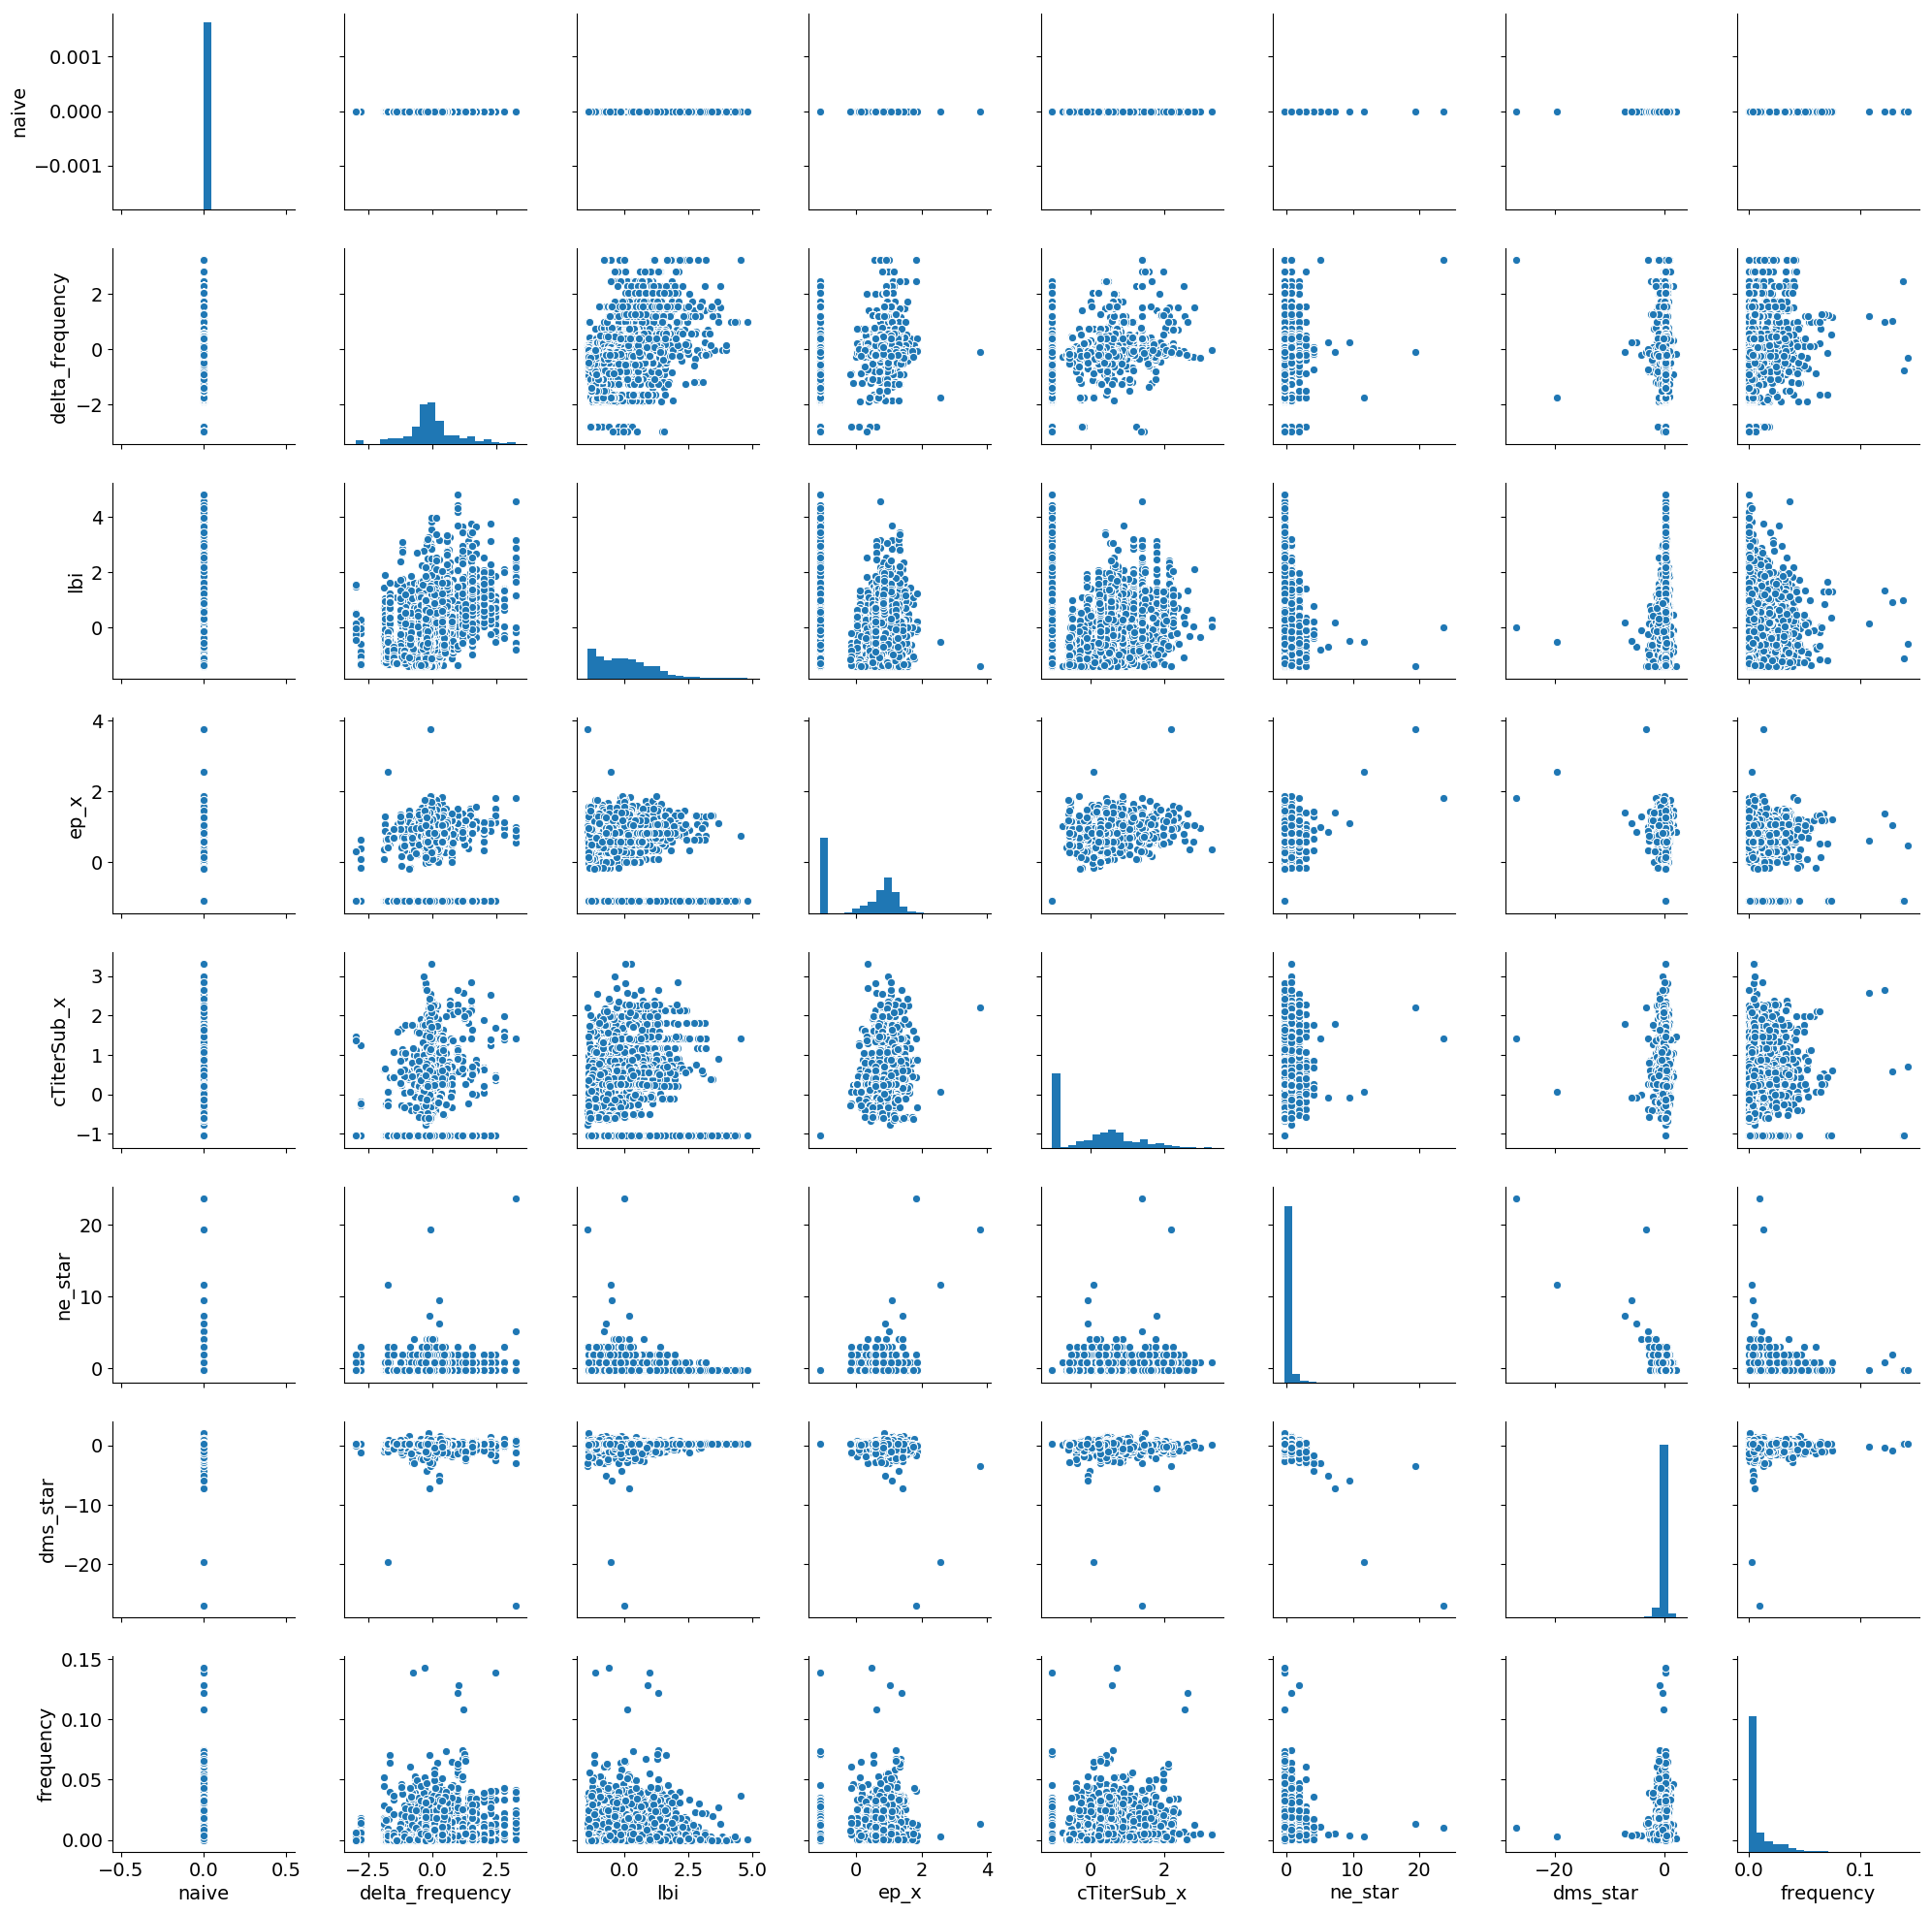

In [507]:
sns.pairplot(tip_attributes_df, vars=predictor_names_order + ["frequency"], diag_kind="hist", diag_kws={"bins": 20})

## Summarize model residuals

In [508]:
residuals_by_timepoint = residual_df.groupby(["predictors", "timepoint"])["residual"].sum().reset_index()

In [509]:
residuals_by_timepoint.head()

,predictors,timepoint,residual
0,cTiterSub_x,2004-10-01,-0.069339
1,cTiterSub_x,2005-04-01,-0.000002
2,cTiterSub_x,2005-10-01,-0.000003
3,cTiterSub_x,2006-04-01,-0.000008
4,cTiterSub_x,2006-10-01,0.000010


In [510]:
residuals_by_timepoint.groupby("predictors")["residual"].sum()

predictors
cTiterSub_x       -0.207658
delta_frequency   -0.207658
dms_star          -0.207658
ep_x              -0.207658
lbi               -0.207658
naive             -0.207658
ne_star           -0.207658
Name: residual, dtype: float64

In [511]:
model_name = "lbi"

In [512]:
model_residuals_by_timepoint = residuals_by_timepoint[residuals_by_timepoint["predictors"] == model_name]

In [513]:
max_lags

18

Text(0,0.5,'Number of clades')

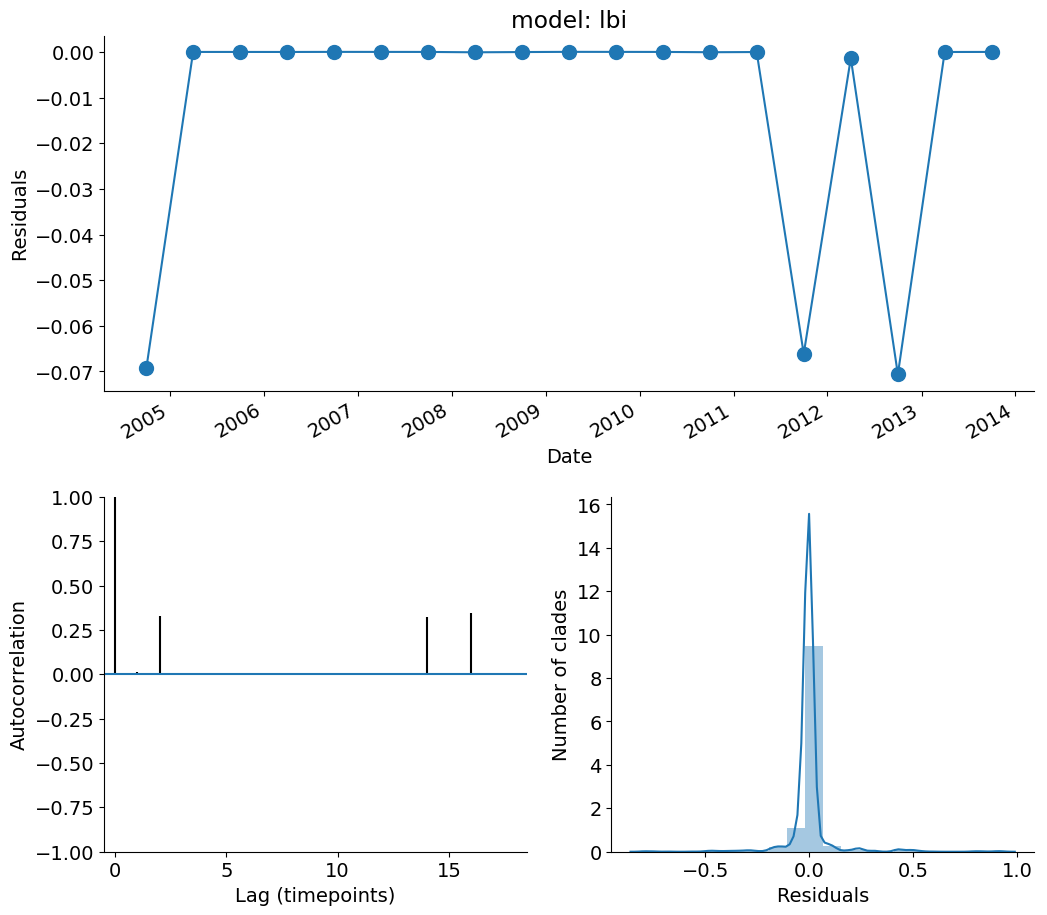

In [514]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2)
gs.update(hspace=0.3)

ax1 = plt.subplot(gs[0, :])
ax1.plot(model_residuals_by_timepoint["timepoint"], model_residuals_by_timepoint["residual"], "o-", markersize=10)
ax1.set_xlabel("Date")
ax1.set_ylabel("Residuals")
ax1.set_title("model: %s" % model_name)
plt.gcf().autofmt_xdate()

ax2 = plt.subplot(gs[1, :-1])
max_lags = len(model_residuals_by_timepoint["residual"]) - 1
lags, autocorrelation, lines, horizonal_lines = ax2.acorr(
    model_residuals_by_timepoint["residual"],
    maxlags=max_lags
)
ax2.set_xlabel("Lag (timepoints)")
ax2.set_ylabel("Autocorrelation")
ax2.set_xlim(-0.5, max_lags + 0.5)
ax2.set_ylim(-1, 1)

ax3 = plt.subplot(gs[1:, -1])
sns.distplot(residual_df.loc[residual_df["predictors"] == model_name, "residual"], ax=ax3, bins=20)
ax3.set_xlabel("Residuals")
ax3.set_ylabel("Number of clades")

In [515]:
residual_df.head()

,clade_membership,frequency,timepoint,frequency_hat,residual,validation_timepoint,predictors
0,00ed6d2,0.0,2004-10-01,0.000436,-0.000436,2009-10-01,dms_star
1,21b8d11,0.0,2004-10-01,0.036694,-0.036694,2009-10-01,dms_star
2,482757a,0.0,2004-10-01,0.050692,-0.050692,2009-10-01,dms_star
3,4ad176b,0.0,2004-10-01,0.150463,-0.150463,2009-10-01,dms_star
4,57fdf76,0.0,2004-10-01,0.012161,-0.012161,2009-10-01,dms_star


### Residuals by predictor

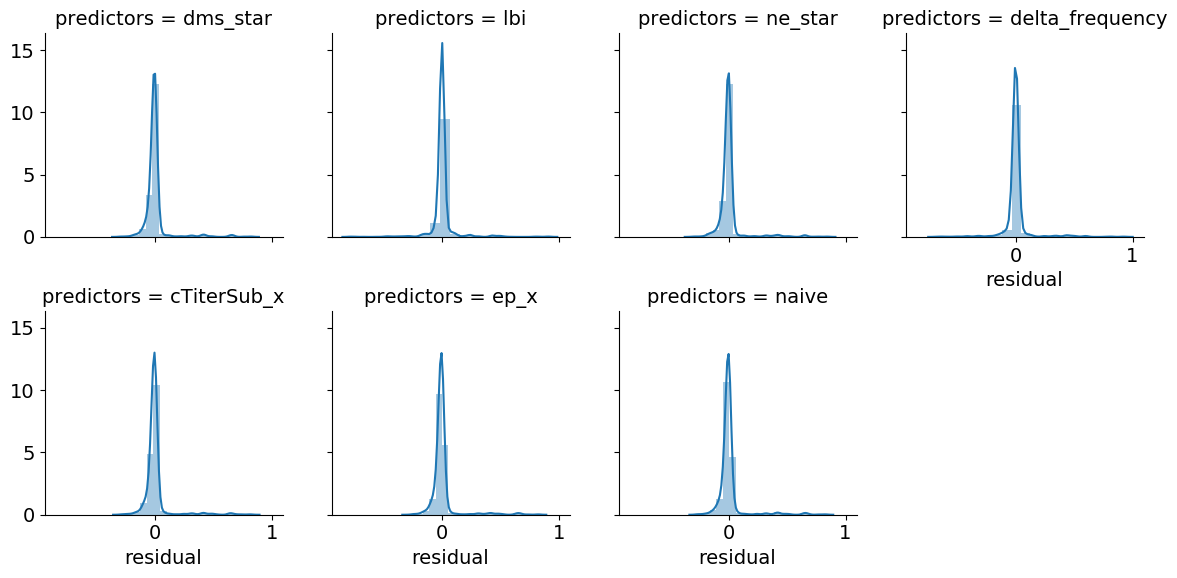

In [516]:
g = sns.FacetGrid(residual_df, col="predictors", col_wrap=4)
g.map(sns.distplot, "residual", bins=20)

In [517]:
residual_df.groupby("predictors")["residual"].median().sort_values()

predictors
naive             -0.007552
ep_x              -0.007281
cTiterSub_x       -0.006869
dms_star          -0.006491
ne_star           -0.005826
delta_frequency   -0.001597
lbi               -0.000570
Name: residual, dtype: float64

In [518]:
residual_df.groupby("predictors")["residual"].count()

predictors
cTiterSub_x        2939
delta_frequency    2939
dms_star           2939
ep_x               2939
lbi                2939
naive              2939
ne_star            2939
Name: residual, dtype: int64

In [519]:
(residual_df["residual"] < -0.01).sum()

7679

### Residuals by timepoint

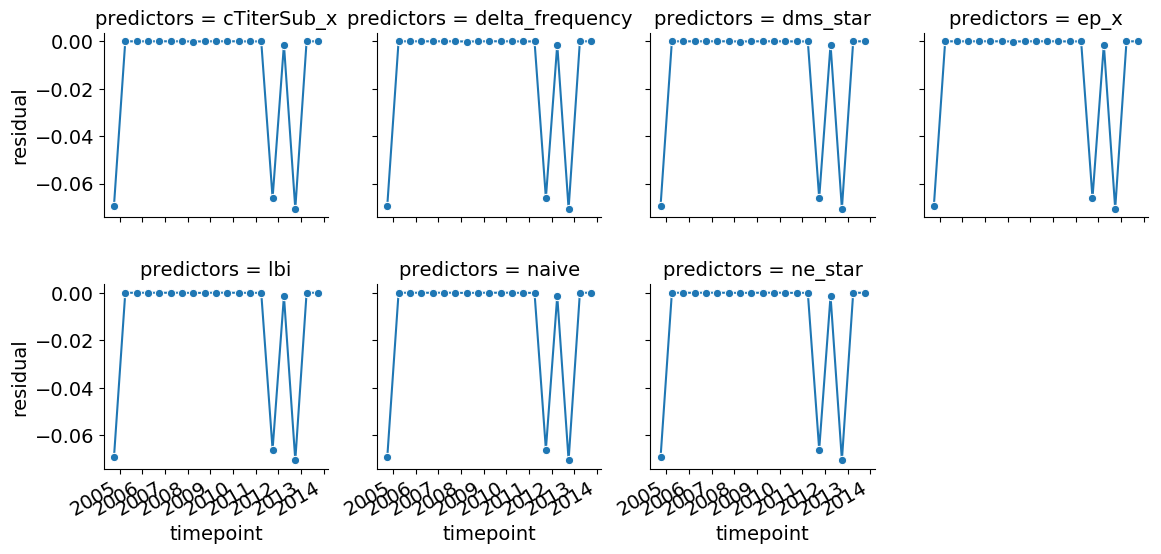

In [520]:
g = sns.FacetGrid(residuals_by_timepoint, col="predictors", col_wrap=4)
g.map(sns.lineplot, "timepoint", "residual", marker="o", linestyle="")
plt.gcf().autofmt_xdate()

In [521]:
np.abs(residuals_by_timepoint[residuals_by_timepoint["predictors"] == "lbi"]["residual"].values - residuals_by_timepoint[residuals_by_timepoint["predictors"] == "naive"]["residual"].values)

array([5.55111512e-17, 2.99239800e-17, 7.63278329e-17, 4.35141154e-16,
       9.19403442e-17, 1.28889954e-15, 4.46637085e-16, 5.28223298e-16,
       2.86229374e-16, 1.23767099e-15, 1.63232058e-15, 1.14979640e-15,
       5.42968448e-16, 7.42136387e-16, 1.38777878e-17, 1.43331527e-16,
       5.41233725e-16, 2.56847495e-16, 7.30752264e-17])

### Autocorrelation of residuals

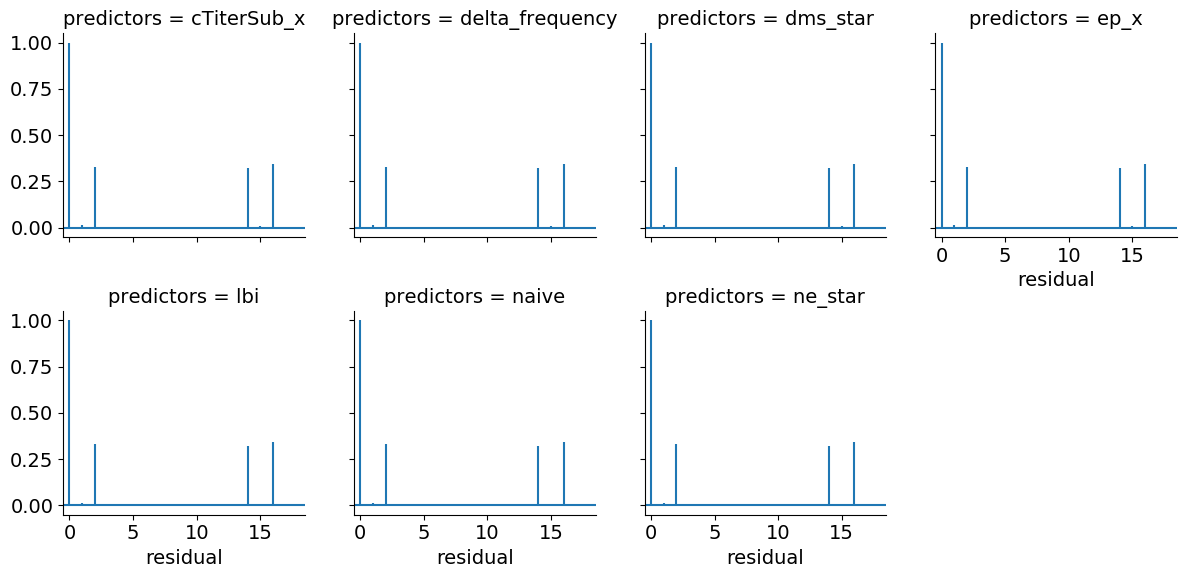

In [522]:
g = sns.FacetGrid(residuals_by_timepoint, col="predictors", col_wrap=4)
g.map(plt.acorr, "residual", maxlags=max_lags)

for ax in g.axes.flatten():
    ax.set_xlim(-0.5, max_lags + 0.5)

## Summarize observed and predicted frequencies and growth rates

### Observed and predicted frequencies

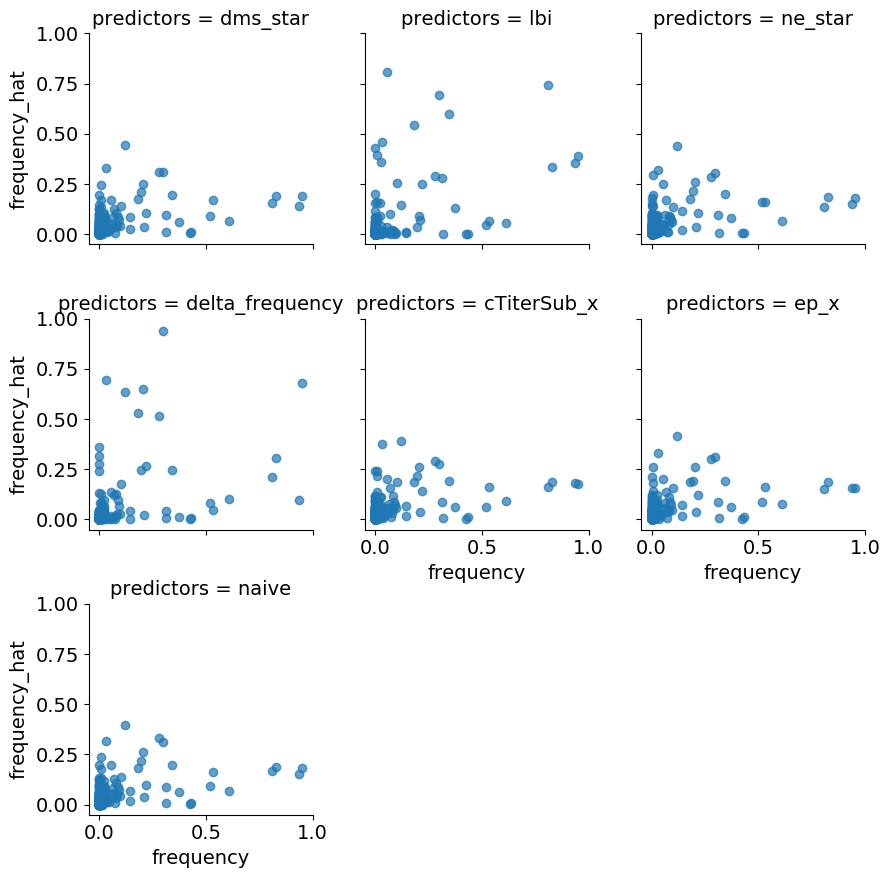

In [523]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=3)
g.map(plt.plot, "frequency", "frequency_hat", marker="o", linestyle="", alpha=0.7)

for ax in g.axes.flatten():
    ax.set_xlim(-0.05, 1)
    ax.set_ylim(-0.05, 1)

### Observed and predicted growth rates

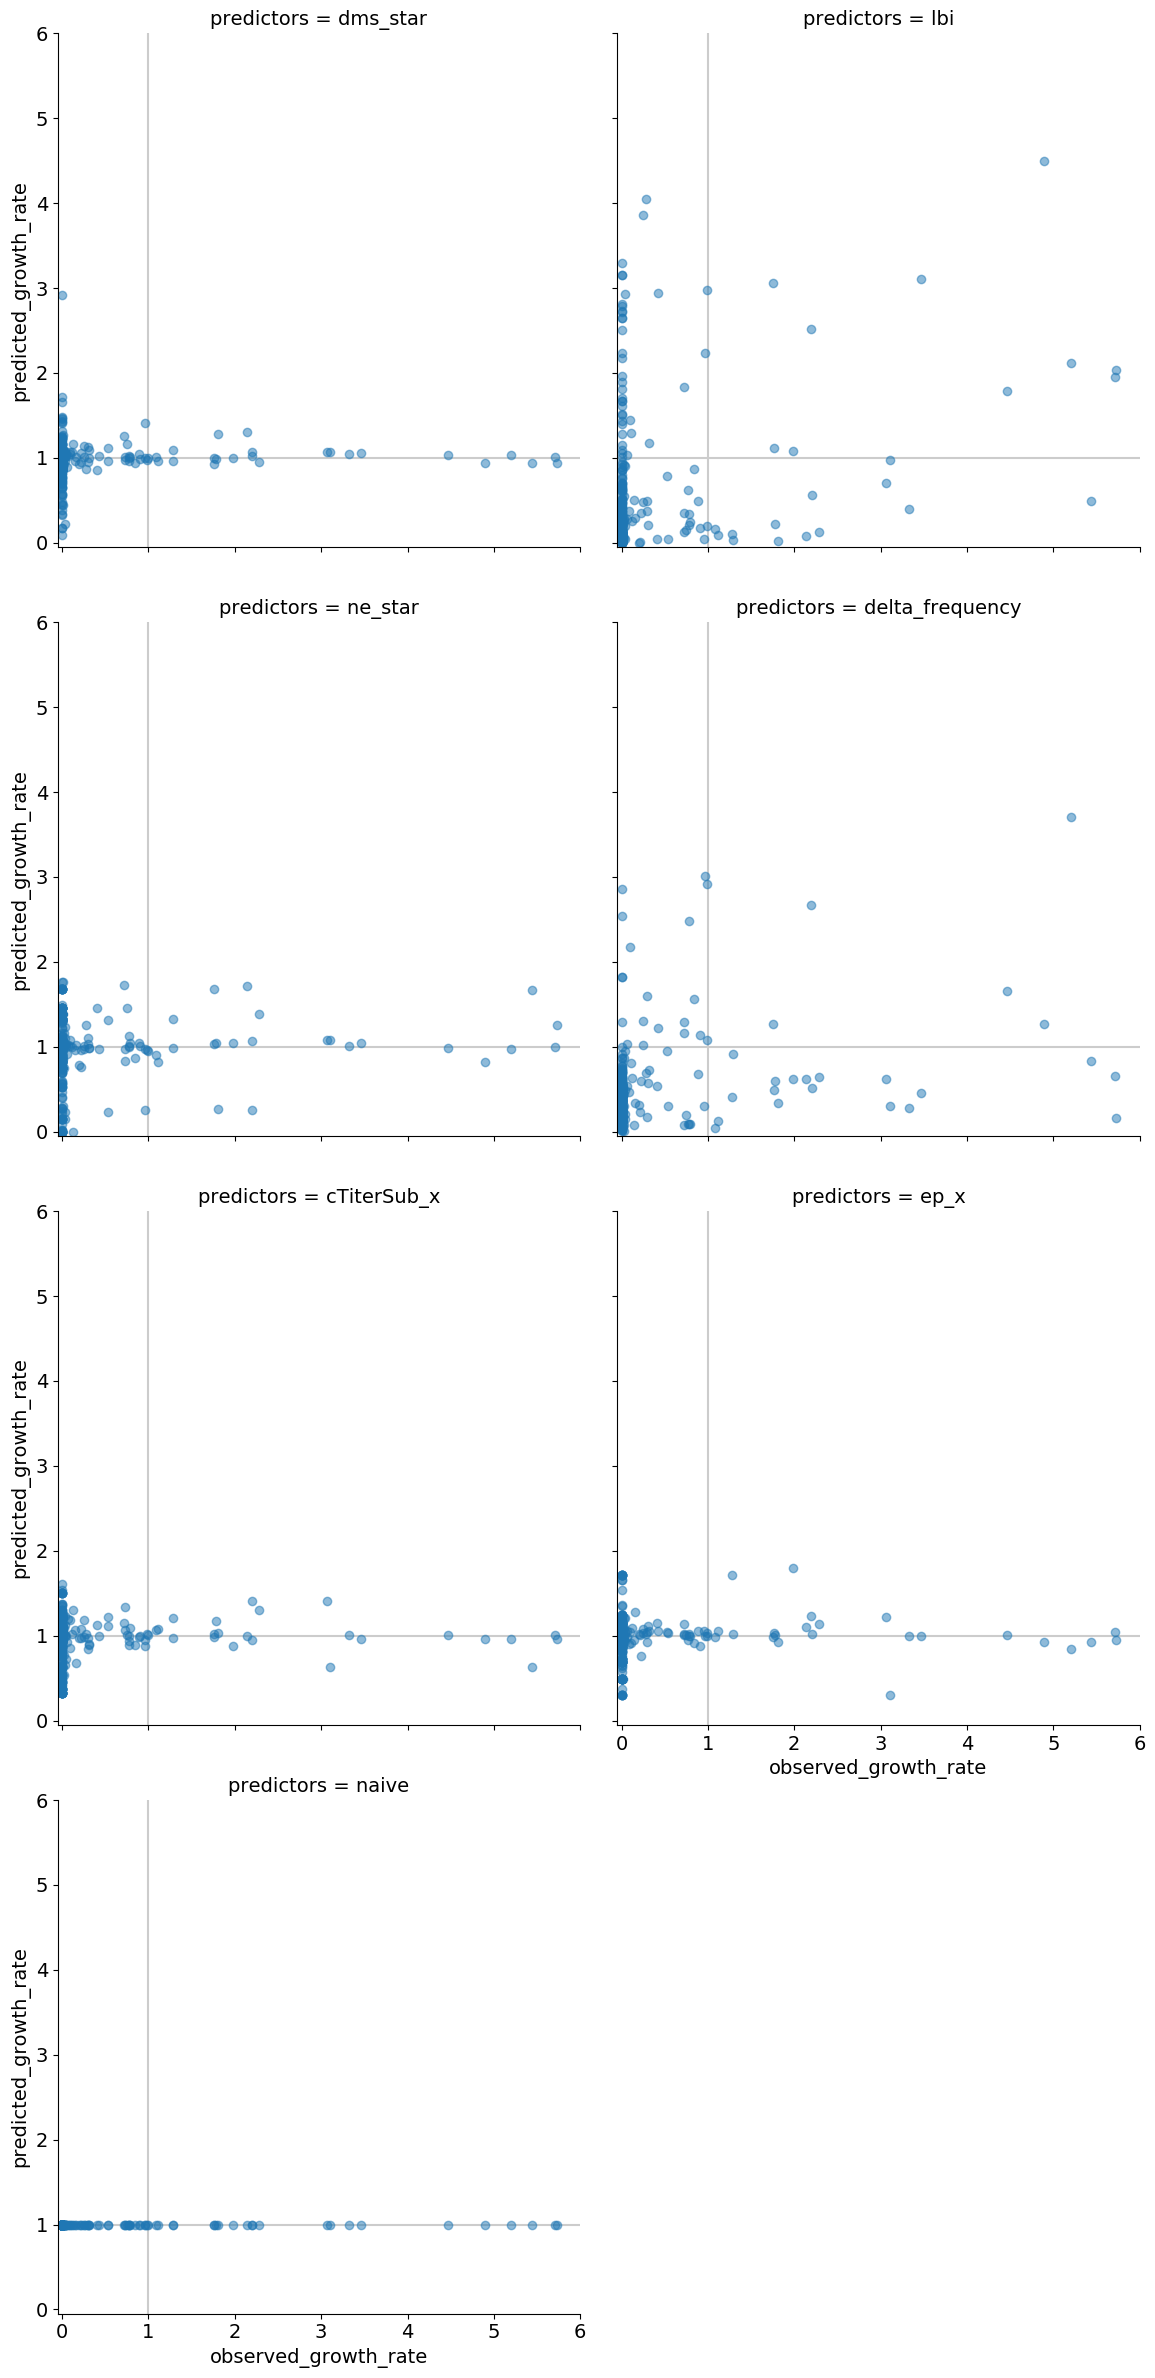

In [524]:
g = sns.FacetGrid(frequency_df, col="predictors", col_wrap=2, height=6, aspect=1.)
g.map(plt.plot, "observed_growth_rate", "predicted_growth_rate", marker="o", linestyle="", alpha=0.5)

for ax in g.axes.flatten():
    ax.axhline(y=1.0, color="#cccccc", zorder=-10)
    ax.axvline(x=1.0, color="#cccccc", zorder=-10)
    ax.set_xlim(-0.05, 6)
    ax.set_ylim(-0.05, 6)

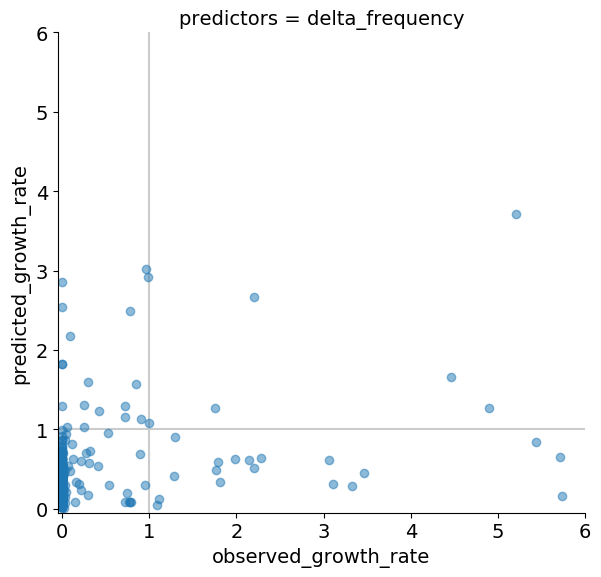

In [525]:
g = sns.FacetGrid(frequency_df[frequency_df["predictors"] == "delta_frequency"], col="predictors", col_wrap=2, height=6, aspect=1.)
g.map(plt.plot, "observed_growth_rate", "predicted_growth_rate", marker="o", linestyle="", alpha=0.5)

for ax in g.axes.flatten():
    ax.axhline(y=1.0, color="#cccccc", zorder=-10)
    ax.axvline(x=1.0, color="#cccccc", zorder=-10)
    ax.set_xlim(-0.05, 6)
    ax.set_ylim(-0.05, 6)

In [526]:
frequency_df.head()

,clade_membership,frequency,timepoint,frequency_hat,frequency_init,residual,observed_growth_rate,predicted_growth_rate,validation_timepoint,predictors
0,0818a58,0.0,2009-10-01,0.012872,0.013639,-0.012872,0.0,0.943755,2009-10-01,dms_star
1,0950450,0.0,2009-10-01,0.027919,0.022586,-0.027919,0.0,1.236125,2009-10-01,dms_star
2,1d941a7,0.0,2009-10-01,0.002690,0.002850,-0.002690,0.0,0.943755,2009-10-01,dms_star
3,2a37b1d,0.0,2009-10-01,0.008808,0.007391,-0.008808,0.0,1.191766,2009-10-01,dms_star
4,2c4373a,0.0,2009-10-01,0.013913,0.014742,-0.013913,0.0,0.943755,2009-10-01,dms_star


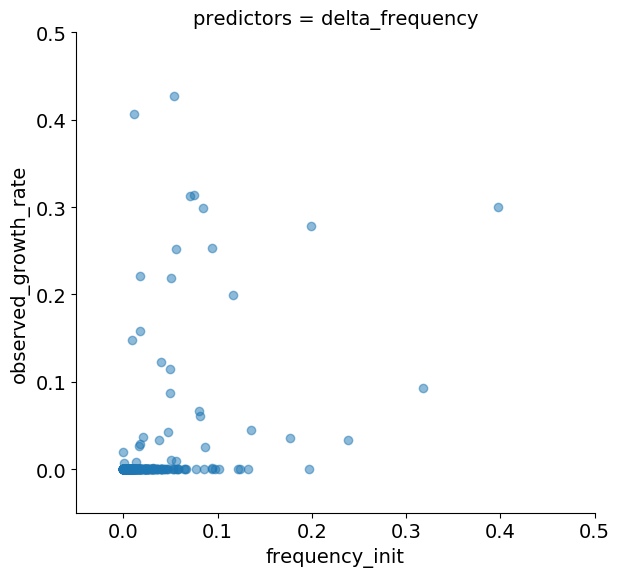

In [527]:
g = sns.FacetGrid(frequency_df[frequency_df["predictors"] == "delta_frequency"], col="predictors", col_wrap=2, height=6, aspect=1.)
g.map(plt.plot, "frequency_init", "observed_growth_rate", marker="o", linestyle="", alpha=0.5)

for ax in g.axes.flatten():
    ax.axhline(y=1.0, color="#cccccc", zorder=-10)
    ax.axvline(x=1.0, color="#cccccc", zorder=-10)
    ax.set_xlim(-0.05, 0.5)
    ax.set_ylim(-0.05, 0.5)

In [528]:
frequency_df.loc[frequency_df["observed_growth_rate"].idxmax()]

clade_membership                     ee6085f
frequency                           0.013733
timepoint                2012-04-01 00:00:00
frequency_hat                    1.16545e-06
frequency_init                         1e-06
residual                           0.0137318
observed_growth_rate                   13733
predicted_growth_rate                1.16545
validation_timepoint     2012-04-01 00:00:00
predictors                          dms_star
Name: 182, dtype: object

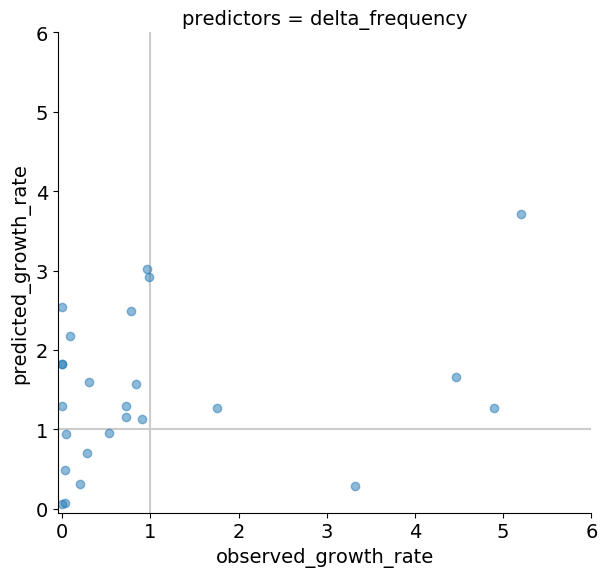

In [529]:
g = sns.FacetGrid(frequency_df[(frequency_df["predictors"] == "delta_frequency") & (frequency_df["frequency_init"] > 0.1)], col="predictors", col_wrap=2, height=6, aspect=1.)
g.map(plt.plot, "observed_growth_rate", "predicted_growth_rate", marker="o", linestyle="", alpha=0.5)

for ax in g.axes.flatten():
    ax.axhline(y=1.0, color="#cccccc", zorder=-10)
    ax.axvline(x=1.0, color="#cccccc", zorder=-10)
    ax.set_xlim(-0.05, 6)
    ax.set_ylim(-0.05, 6)

## Summarize model forecasting error

In [530]:
mae_df = frequency_df.groupby("predictors").apply(
    lambda group_df: mean_absolute_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "mae"})

In [531]:
mae_df.sort_values("mae")

,predictors,mae
4,lbi,0.037438
1,delta_frequency,0.040106
6,ne_star,0.040616
0,cTiterSub_x,0.040801
2,dms_star,0.040958
3,ep_x,0.041042
5,naive,0.041078


In [532]:
mae_by_timepoint_df = frequency_df.groupby(["predictors", "validation_timepoint"]).apply(
    lambda group_df: mean_absolute_error(group_df["frequency"], group_df["frequency_hat"])
).reset_index().rename(columns={0: "mae"})

In [533]:
mae_by_timepoint_df.head()

,predictors,validation_timepoint,mae
0,cTiterSub_x,2009-10-01,0.041451
1,cTiterSub_x,2010-04-01,0.035417
2,cTiterSub_x,2010-10-01,0.036959
3,cTiterSub_x,2011-04-01,0.040363
4,cTiterSub_x,2011-10-01,0.027718


In [534]:
naive_mae = mae_by_timepoint_df[mae_by_timepoint_df["predictors"] == "naive"]["mae"].values
for predictor in mae_by_timepoint_df["predictors"].drop_duplicates().values:
    mae_by_timepoint_df.loc[mae_by_timepoint_df["predictors"] == predictor, "adjusted_mae"] =  mae_by_timepoint_df.loc[mae_by_timepoint_df["predictors"] == predictor, "mae"] - naive_mae

In [535]:
mae_df["adjusted_mae"] = mae_df["mae"] - mae_df[mae_df["predictors"] == "naive"]["mae"].iloc[0]

In [536]:
overall_errors_df.head()

,cv_error_mean,cv_error_std,predictors
0,0.040948,0.007971,dms_star
1,0.037388,0.013301,lbi
2,0.040610,0.008870,ne_star
3,0.040431,0.009529,delta_frequency
4,0.040802,0.006976,cTiterSub_x


(0, 0.041920705014973234)

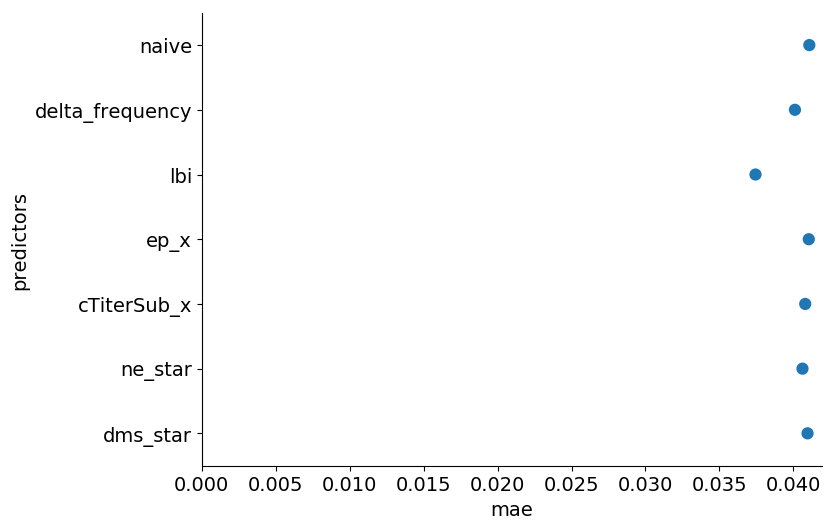

In [537]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="mae",
    y="predictors",
    data=mae_df,
    join=False,
    order=predictor_names_order,
    ax=ax
)
ax.set_xlim(left=0)

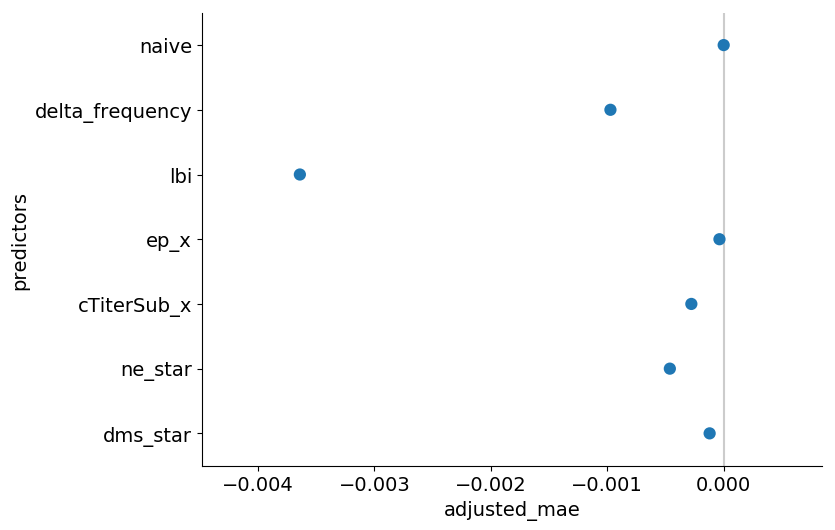

In [538]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    x="adjusted_mae",
    y="predictors",
    data=mae_df,
    join=False,
    order=predictor_names_order,
    ax=ax
)
ax.axvline(x=0.0, color="#cccccc", zorder=-10)
#ax.set_xlim(left=0)

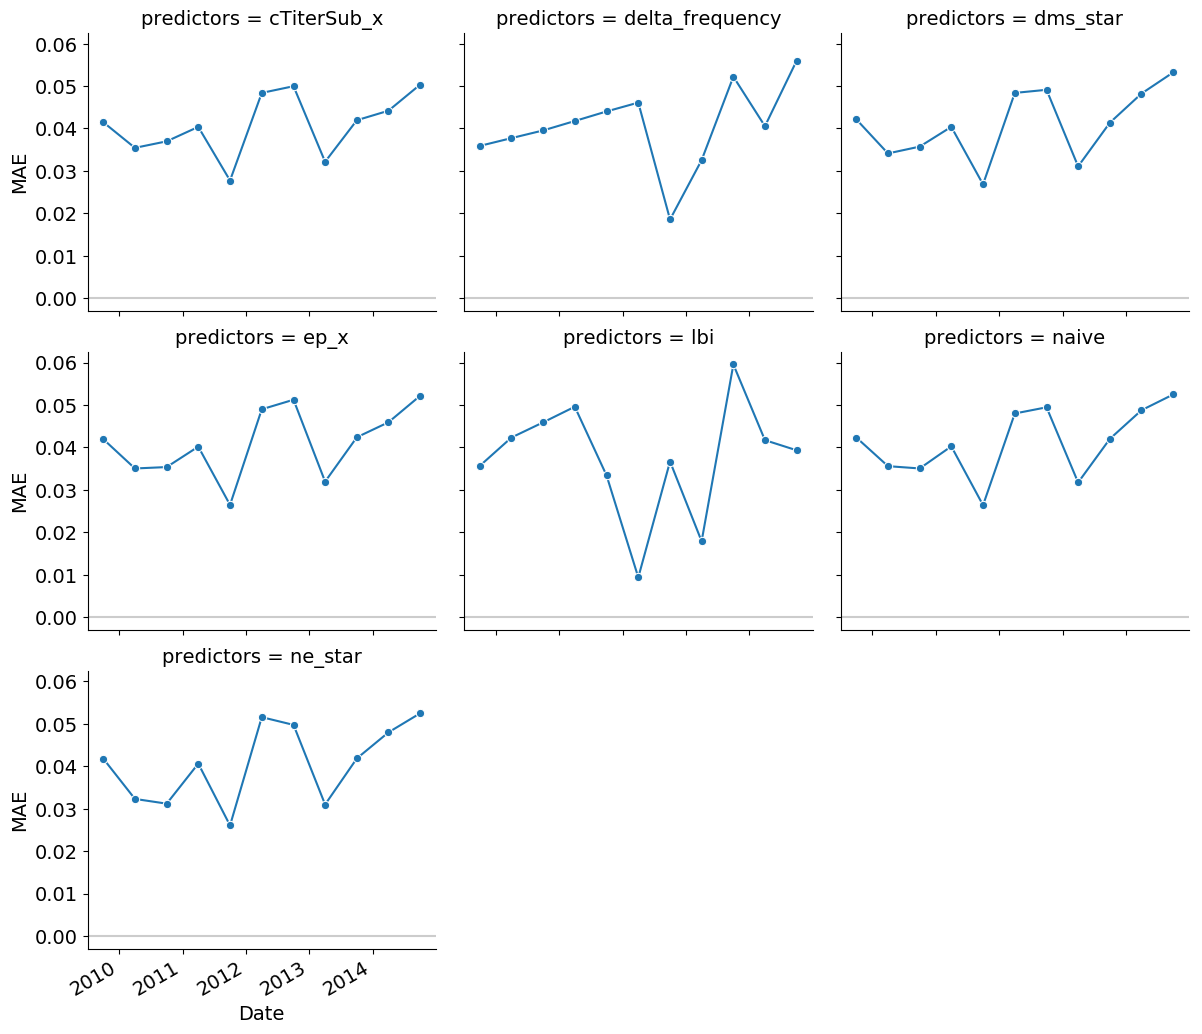

In [539]:
g = facet_time_plot(mae_by_timepoint_df, "mae", "MAE", timepoint_column="validation_timepoint")

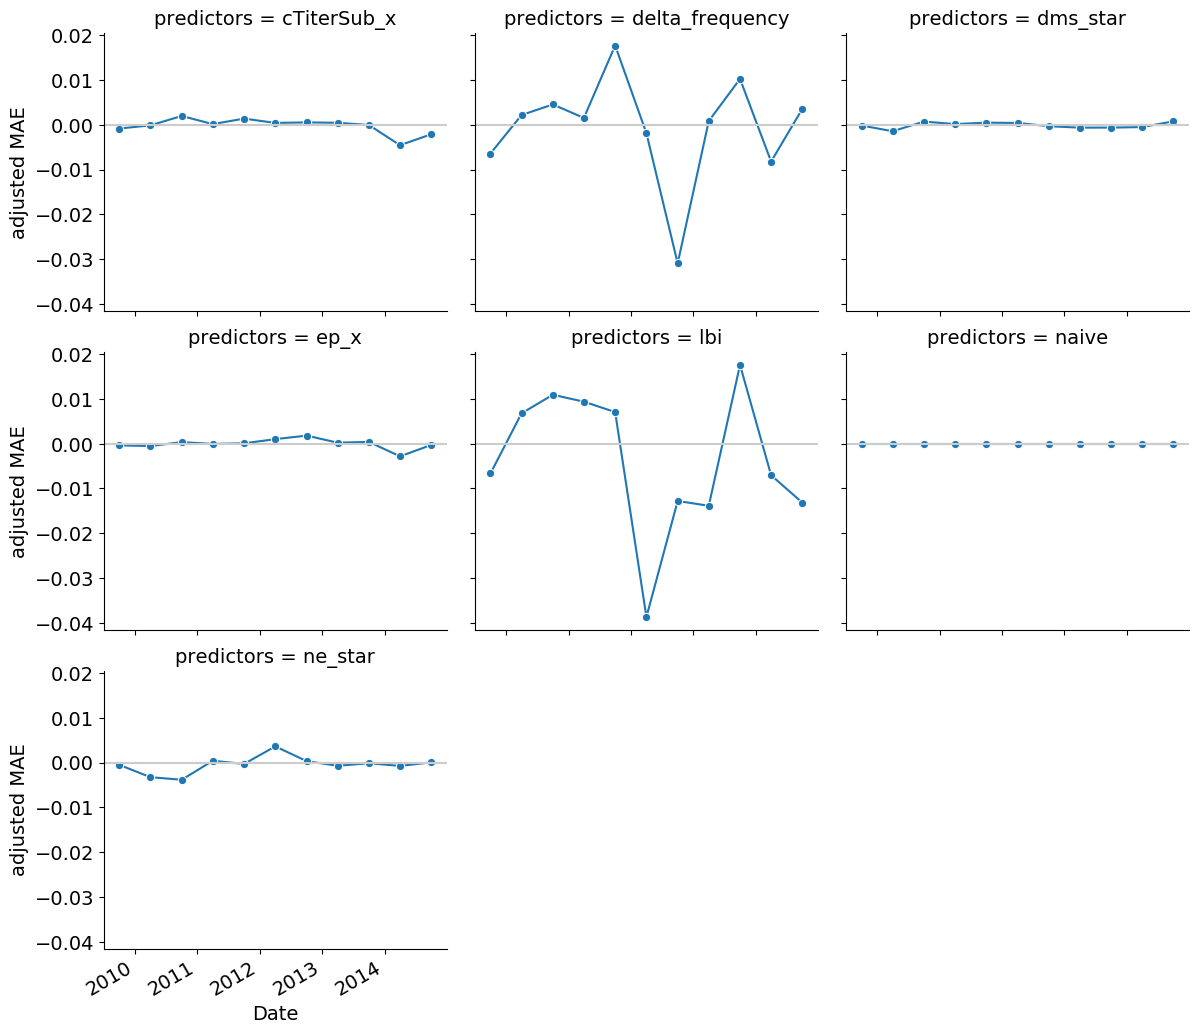

In [540]:
g = facet_time_plot(mae_by_timepoint_df, "adjusted_mae", "adjusted MAE", timepoint_column="validation_timepoint")

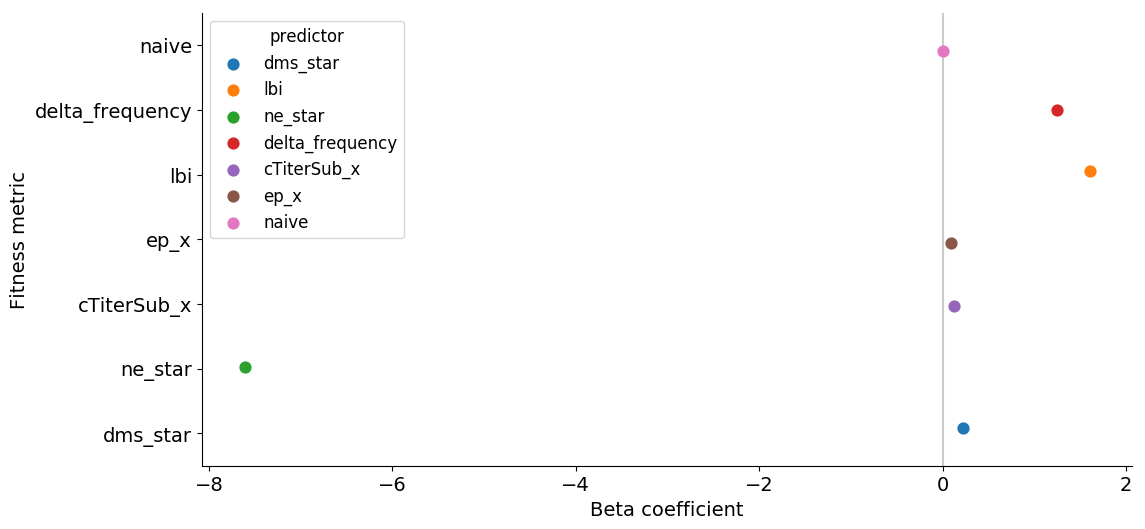

In [541]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.pointplot(
    y="predictors",
    x="mean",
    hue="predictor",
    data=overall_coefficients_df,
    ax=ax,
    dodge=True,
    join=False,
    order=predictor_names_order
)

ax.axvline(0, color="#999999", alpha=0.5, zorder=-10)
ax.set_xlabel("Beta coefficient")
ax.set_ylabel("Fitness metric")

sns.despine()

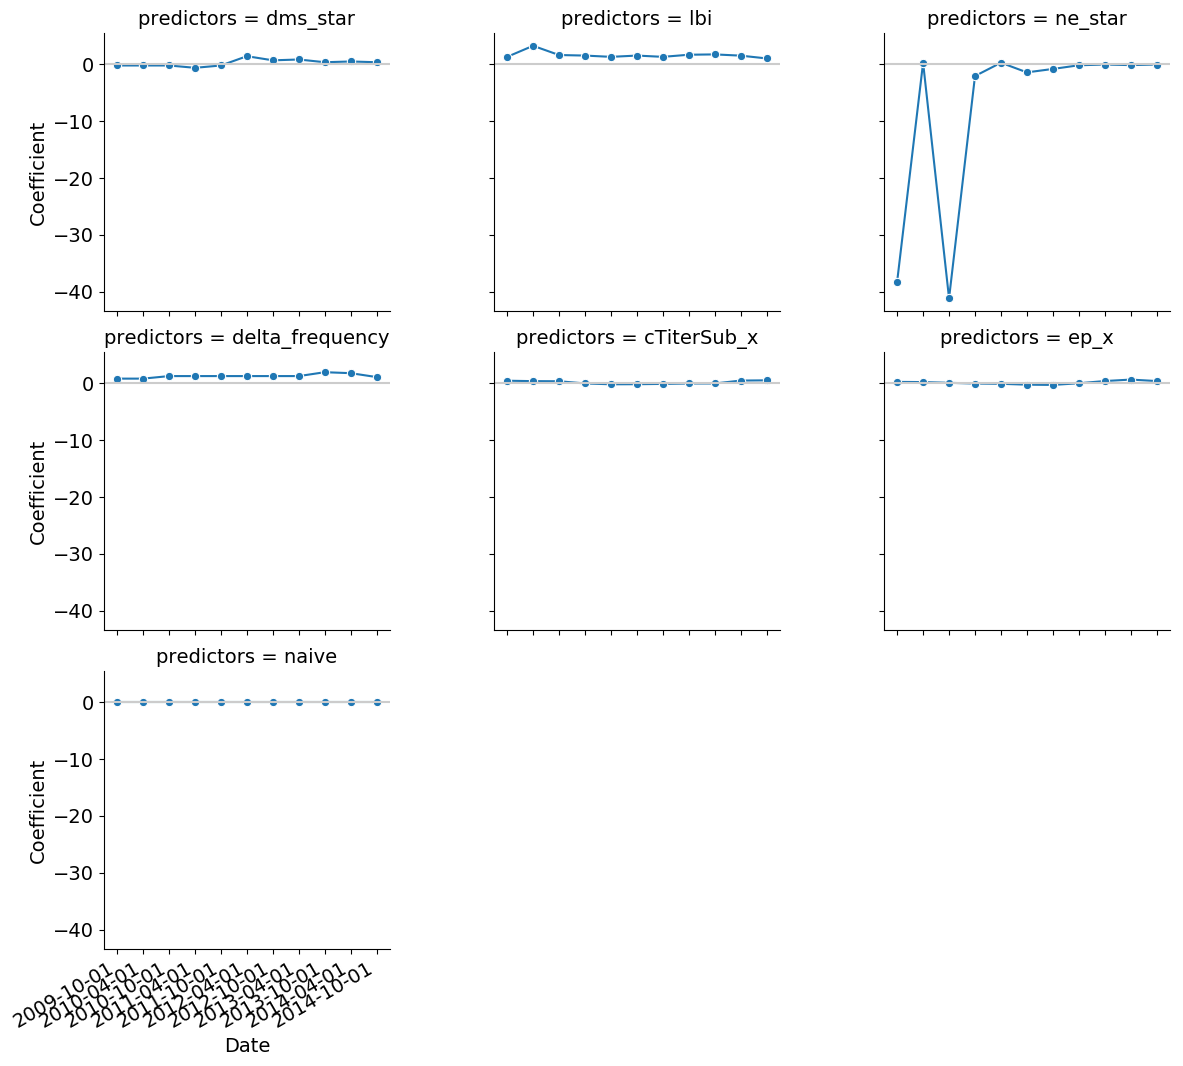

In [542]:
g = facet_time_plot(coefficients_by_time_df, "coefficient", "Coefficient", timepoint_column="validation_timepoint")